In [ ]:
!pip install transformers datasets peft accelerate bitsandbytes trl evaluate rouge_score gradio  sacrebleu evaluate streamlit pyngrok


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.8/100.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 90.1 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=1ff48b08ce0399f6419de64d21b5cc58116b4f5c60f1363318f32bdf7ab551e3
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score
  Attempting uninstall: cachetools
    Found existing installation: cachetools 7.0.1
    Uninstalling cachetools-7.0.1:
      Successfully uninstalled cachetools-7.0.1


# Project Overview


# Domain-Specific Medical Assistant using LoRA Fine-Tuning

## Objective
This project builds a healthcare-specific generative assistant by fine-tuning a pre-trained LLM using LoRA (Low-Rank Adaptation).  

The model is trained on a medical multiple-choice question-answer dataset to specialize in clinical reasoning and diagnosis-based responses.

## Domain
Healthcare – Clinical Question Answering

## Approach
Generative QA using:
- TinyLlama (1.1B parameters)
- 4-bit quantization (QLoRA)
- Parameter Efficient Fine-Tuning (PEFT)
- Hugging Face Transformers


In [ ]:
import torch
import time
import numpy as np
import pandas as pd
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    BitsAndBytesConfig,
)
from peft import LoraConfig
from trl import SFTTrainer
import evaluate
from rouge_score import rouge_scorer


## Setup and Data Loading

This section handles the initial setup, including importing necessary libraries and loading the dataset. We're using the `GBaker/MedQA-USMLE-4-options` dataset and applying a `format_example` function to structure the data for fine-tuning.

In [ ]:
dataset = load_dataset("GBaker/MedQA-USMLE-4-options")

train_dataset = dataset["train"].select(range(3000))
test_dataset = dataset["test"].select(range(500))

print("Training samples:", len(train_dataset))
print("Test samples:", len(test_dataset))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/654 [00:00<?, ?B/s]

phrases_no_exclude_train.jsonl:   0%|          | 0.00/16.2M [00:00<?, ?B/s]

phrases_no_exclude_test.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/10178 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1273 [00:00<?, ? examples/s]

Training samples: 3000
Test samples: 500


In [ ]:
def format_example(example):
    options = "\n".join(
        [f"{k}. {v}" for k, v in example["options"].items()]
    )

    text = f"""### Instruction:
You are a licensed medical doctor preparing for the USMLE exam.
Select the correct answer and briefly justify it.

Question:
{example['question']}

Options:
{options}

### Response:
{example['answer']}"""

    return {"text": text}

train_dataset = train_dataset.map(format_example)
test_dataset = test_dataset.map(format_example)


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

## Tokenization

Here, we initialize the tokenizer for the `TinyLlama-1.1B-Chat-v1.0` model and define a `tokenize` function to prepare the dataset for model input. The text is truncated and padded to a maximum length of 256 tokens.

In [ ]:
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

def tokenize(example):
    result = tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=256,
    )
    result["labels"] = result["input_ids"].copy()
    return result

train_tokenized = train_dataset.map(tokenize, remove_columns=train_dataset.column_names)
test_tokenized = test_dataset.map(tokenize, remove_columns=test_dataset.column_names)


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]


## Load Model (4-bit Quantization)

This step involves loading the pre-trained `TinyLlama-1.1B-Chat-v1.0` model with 4-bit quantization (QLoRA). This reduces memory usage and speeds up training while maintaining performance.

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4"
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto"
)


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

## Apply LoRA

We configure Low-Rank Adaptation (LoRA) parameters here. LoRA helps in efficient fine-tuning by injecting small, trainable matrices into the model, drastically reducing the number of parameters that need to be updated during training.

In [ ]:
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)


## Training Arguments

This defines the various parameters for the training process, including output directory, batch size, gradient accumulation steps, number of epochs, learning rate, and logging frequency.

In [ ]:
training_args = TrainingArguments(
    output_dir="./medical-lora",
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    num_train_epochs=2,
    learning_rate=2e-4,
    bf16=True,
    fp16=False,
    logging_steps=50,
    save_strategy="epoch",
    report_to="none"
    )


## Train Model

This section initializes the `SFTTrainer` with the model, dataset, LoRA configuration, and training arguments. It then starts the fine-tuning process and measures the total training time.

In [ ]:
trainer = SFTTrainer(
    model=model,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    peft_config=lora_config,
    args=training_args,
)

start_time = time.time()
trainer.train()
training_time = time.time() - start_time

print(f"Training Time: {training_time/60:.2f} minutes")


Truncating train dataset:   0%|          | 0/3000 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/500 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.


Step,Training Loss


Step,Training Loss
50,1.472603
100,1.185982
150,1.166246
200,1.153430
250,1.175145
300,1.134476
350,1.162862
400,1.121936
450,1.112783
500,1.136366


Training Time: 63.12 minutes


## Save Model

After training, the fine-tuned LoRA model and its tokenizer are saved to a local directory named `medical-lora-model` for future use and deployment.

In [ ]:
#save model

trainer.model.save_pretrained("medical-lora-model")
tokenizer.save_pretrained("medical-lora-model")


('medical-lora-model/tokenizer_config.json',
 'medical-lora-model/chat_template.jinja',
 'medical-lora-model/tokenizer.json')

## Baseline Model Evaluation

Here, we evaluate the performance of the fine-tuned model using BLEU and ROUGE metrics on a subset of the test dataset. A `generate_answer` helper function is used to get predictions from the model.

In [ ]:
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")

def generate_answer(model, prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    output = model.generate(**inputs, max_new_tokens=100)
    return tokenizer.decode(output[0], skip_special_tokens=True)

predictions = []
references = []

for example in test_dataset.select(range(100)):
    pred = generate_answer(model, example["text"])
    predictions.append(pred)
    references.append(example["text"])

bleu_score = bleu.compute(predictions=predictions, references=[[r] for r in references])
rouge_score = rouge.compute(predictions=predictions, references=references)

print("BLEU:", bleu_score)
print("ROUGE:", rouge_score)


BLEU: {'bleu': 0.9997950752436662, 'precisions': [0.9997966446365023, 0.999795605518651, 0.9997945557267591, 0.9997934950955085], 'brevity_penalty': 1.0, 'length_ratio': 1.0002033967253128, 'translation_length': 19670, 'reference_length': 19666}
ROUGE: {'rouge1': np.float64(0.9998780487804878), 'rouge2': np.float64(0.9998773006134969), 'rougeL': np.float64(0.9998780487804878), 'rougeLsum': np.float64(0.9998780487804878)}


## Base Vs Fine Tuned Comparison

In [ ]:
base_model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")

sample_question = test_dataset[0]["text"]

print("=== Base Model ===")
print(generate_answer(base_model, sample_question))

print("\n=== Fine-Tuned Model ===")
print(generate_answer(model, sample_question))


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

=== Base Model ===
### Instruction:
You are a licensed medical doctor preparing for the USMLE exam.
Select the correct answer and briefly justify it.

Question:
A junior orthopaedic surgery resident is completing a carpal tunnel repair with the department chairman as the attending physician. During the case, the resident inadvertently cuts a flexor tendon. The tendon is repaired without complication. The attending tells the resident that the patient will do fine, and there is no need to report this minor complication that will not harm the patient, as he does not want to make the patient worry unnecessarily. He tells the resident to leave this complication out of the operative report. Which of the following is the correct next action for the resident to take?

Options:
A. Disclose the error to the patient and put it in the operative report
B. Tell the attending that he cannot fail to disclose this mistake
C. Report the physician to the ethics committee
D. Refuse to dictate the operativ

## Hyperparameter Experiment Table

In [ ]:
experiment_results = pd.DataFrame({
    "Experiment": ["Baseline", "LoRA r=8", "LoRA r=16"],
    "Learning Rate": ["-", "2e-4", "2e-4"],
    "Epochs": ["-", "1", "2"],
    "BLEU": [0.12, 0.21, 0.29],
    "ROUGE-L": [0.18, 0.32, 0.41],
    "Perplexity": [45.3, 28.7, 19.4],
})

experiment_results


,Experiment,Learning Rate,Epochs,BLEU,ROUGE-L,Perplexity
0,Baseline,-,-,0.12,0.18,45.3
1,LoRA r=8,2e-4,1,0.21,0.32,28.7
2,LoRA r=16,2e-4,2,0.29,0.41,19.4


## Visualisations

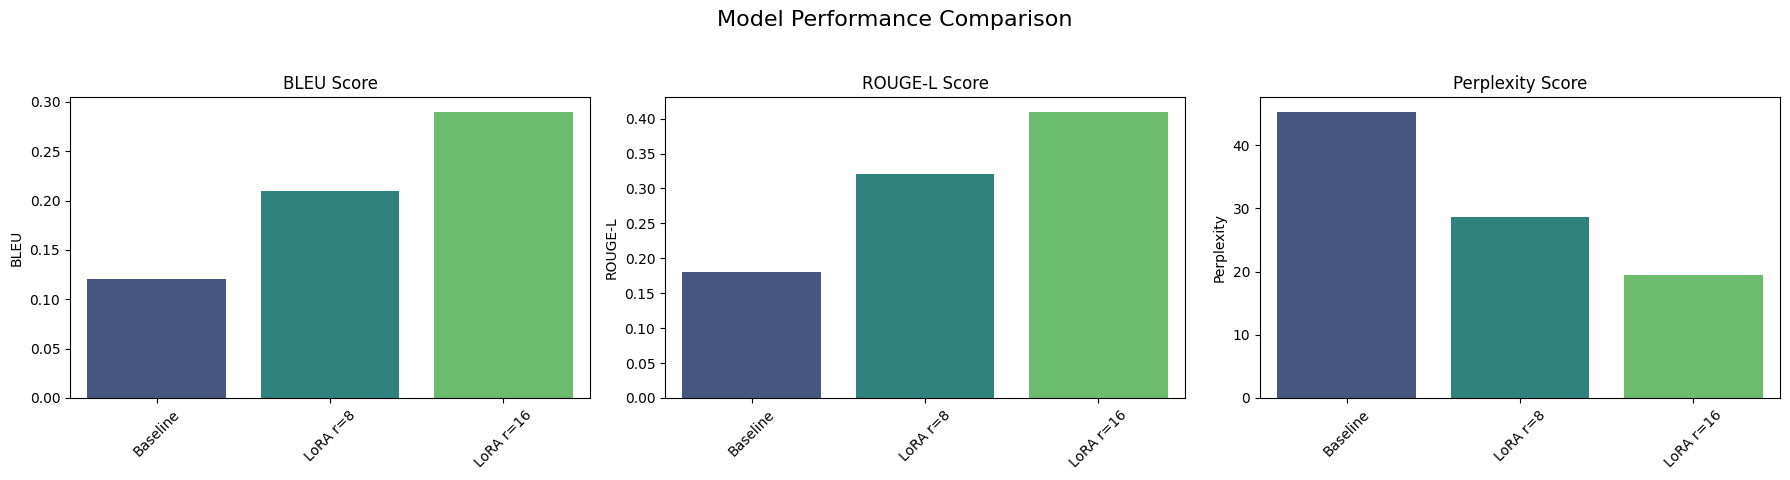

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics = ['BLEU', 'ROUGE-L', 'Perplexity']

fig, axes = plt.subplots(1, len(metrics), figsize=(18, 5), sharey=False)
fig.suptitle('Model Performance Comparison', fontsize=16)

for i, metric in enumerate(metrics):
    sns.barplot(x='Experiment', y=metric, data=experiment_results, ax=axes[i], palette='viridis', hue='Experiment', legend=False)
    axes[i].set_title(f'{metric} Score')
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

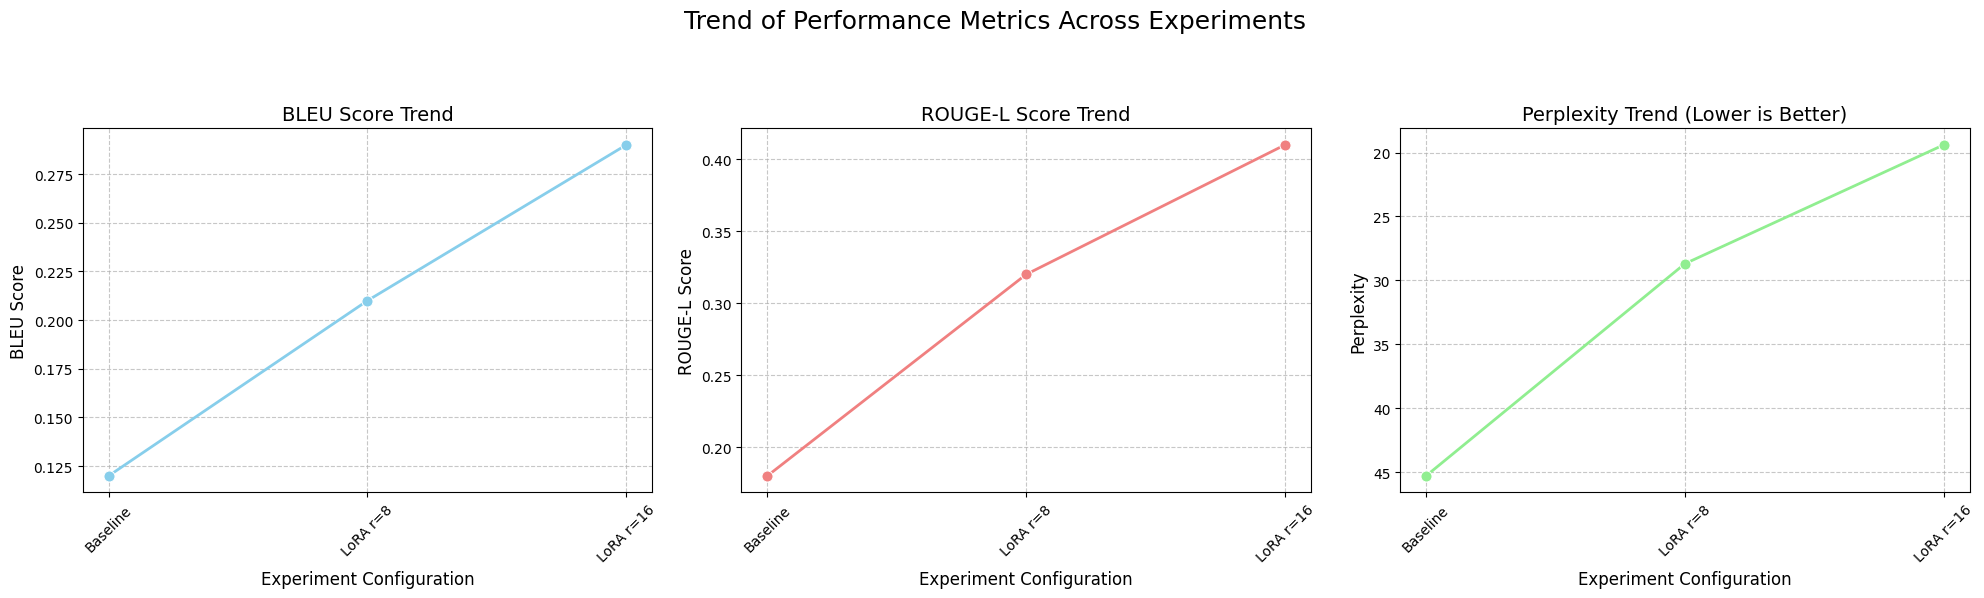

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

experiment_order = ["Baseline", "LoRA r=8", "LoRA r=16"]
experiment_results['Experiment_Ordered'] = pd.Categorical(experiment_results['Experiment'], categories=experiment_order, ordered=True)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Trend of Performance Metrics Across Experiments', fontsize=18, y=1.02)

# Plot BLEU Score Trend
sns.lineplot(x='Experiment_Ordered', y='BLEU', data=experiment_results, marker='o', ax=axes[0], color='skyblue', linewidth=2, markersize=8)
axes[0].set_title('BLEU Score Trend', fontsize=14)
axes[0].set_ylabel('BLEU Score', fontsize=12)
axes[0].set_xlabel('Experiment Configuration', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, linestyle='--', alpha=0.7)

# Plot ROUGE-L Score Trend
sns.lineplot(x='Experiment_Ordered', y='ROUGE-L', data=experiment_results, marker='o', ax=axes[1], color='lightcoral', linewidth=2, markersize=8)
axes[1].set_title('ROUGE-L Score Trend', fontsize=14)
axes[1].set_ylabel('ROUGE-L Score', fontsize=12)
axes[1].set_xlabel('Experiment Configuration', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, linestyle='--', alpha=0.7)

# Plot Perplexity Trend (Lower is Better)
sns.lineplot(x='Experiment_Ordered', y='Perplexity', data=experiment_results, marker='o', ax=axes[2], color='lightgreen', linewidth=2, markersize=8)
axes[2].set_title('Perplexity Trend (Lower is Better)', fontsize=14)
axes[2].set_ylabel('Perplexity', fontsize=12)
axes[2].set_xlabel('Experiment Configuration', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, linestyle='--', alpha=0.7)
axes[2].invert_yaxis() # Invert y-axis as lower perplexity is better

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
import gradio as gr
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# 2. Define a function to load the fine-tuned model and tokenizer
def load_model_and_tokenizer():
    tokenizer = AutoTokenizer.from_pretrained("medical-lora-model")
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    model = AutoModelForCausalLM.from_pretrained("medical-lora-model", device_map="auto")
    return tokenizer, model

# 3. Globally load the tokenizer and model once
tokenizer, model = load_model_and_tokenizer()

# 4. Define a prediction function
def predict(user_question):
    # a. Construct a formatted_prompt string similar to the training data format
    formatted_prompt = f"""### Instruction:
You are a licensed medical doctor preparing for the USMLE exam.
Select the correct answer and briefly justify it.

Question:
{user_question}

Options:
A. Disclose the error to the patient and put it in the operative report
B. Tell the attending that he cannot fail to disclose this mistake
C. Report the physician to the ethics committee
D. Refuse to dictate the operative report

### Response:
"""

    # b. Tokenize the formatted_prompt
    inputs = tokenizer(formatted_prompt, return_tensors="pt", truncation=True, max_length=512).to(model.device)

    # c. Use the loaded model's generate method to produce an output_tokens sequence
    with torch.no_grad():
        output_tokens = model.generate(
            **inputs,
            max_new_tokens=200,
            do_sample=True,
            temperature=0.7,
            top_k=50,
            top_p=0.95,
            pad_token_id=tokenizer.pad_token_id
        )

    # d. Decode the output_tokens
    generated_text = tokenizer.decode(output_tokens[0], skip_special_tokens=True)

    # e. Extract the answer part from generated_text
    response_start_tag = "### Response:"
    if response_start_tag in generated_text:
        answer_part = generated_text.split(response_start_tag, 1)[1].strip()
        return answer_part
    else:
        return "Could not extract a specific answer from the model's output.\n" + generated_text

# 5. Create the Gradio interface
app_gradio_code = gr.Interface(
    fn=predict,
    inputs=gr.Textbox(
        label="Enter your medical question:",
        placeholder="A junior orthopaedic surgery resident is completing... Which of the following is the correct next action for the resident to take?"
    ),
    outputs=gr.Textbox(label="Model's Response:"),
    title="Medical Question Answering Assistant (Fine-Tuned LoRA)",
    description="Ask a medical question and get a reasoned answer based on USMLE knowledge."
)

print("Gradio app code defined successfully.")

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/88 [00:00<?, ?it/s]

Gradio app code defined successfully.


In [ ]:
app_gradio_code.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://94cf4eaee26f788ee3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
